In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [25]:
#Read csv
df=pd.read_csv('/Users/mikel/Documents/Projects/reto_data/measurements.csv')
df.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


# Drop null columns

In [26]:
nan_cols=df.isna().sum()

nan_cols[nan_cols>0]


temp_inside       12
specials         295
refill liters    375
refill gas       375
dtype: int64

In [27]:
df=df.drop(columns=['specials', 'refill liters', 'refill gas'], axis=1)

# Change Dtypes

In [28]:
df.dtypes

distance        object
consume         object
speed            int64
temp_inside     object
temp_outside     int64
gas_type        object
AC               int64
rain             int64
sun              int64
dtype: object

In [30]:
# I had some trouble converting data to float, so I replaced , with .
df['distance']=df['distance'].str.replace(',','.')
df['consume']=df['consume'].str.replace(',','.')
df['temp_inside']=df['temp_inside'].str.replace(',','.')

In [31]:
df['distance']=df['distance'].astype('float')
df['consume']=df['consume'].astype('float')
df['temp_inside']=df['temp_inside'].astype('float')

In [32]:
df.dtypes

distance        float64
consume         float64
speed             int64
temp_inside     float64
temp_outside      int64
gas_type         object
AC                int64
rain              int64
sun               int64
dtype: object

# Correlation matrix

## Lets see how the vairables are related

In [33]:
# Select only numeric data in this first approach
df_numeric=df.select_dtypes(include=['int64', 'float64'])

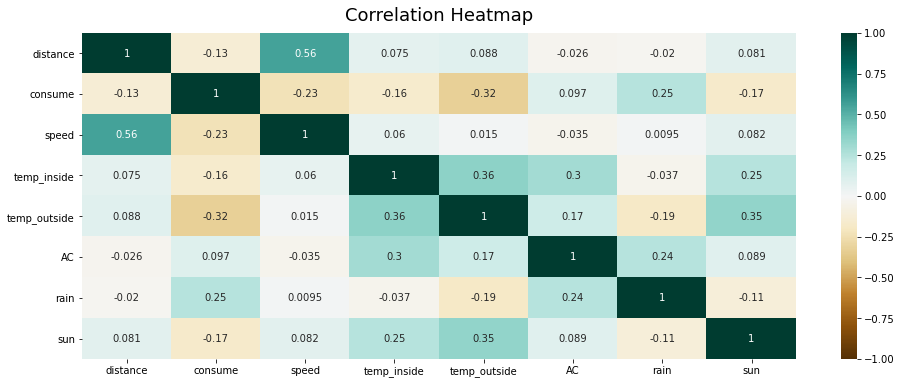

In [34]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_numeric.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

Insights:
1. Speed and distance are positively correlated
2. Consume and tem_outside are negatively correlated, if the temperature is high the consume is lower.
3. If its rainy, the consume is higher, when there is sun, lower.

# Gas type analysis

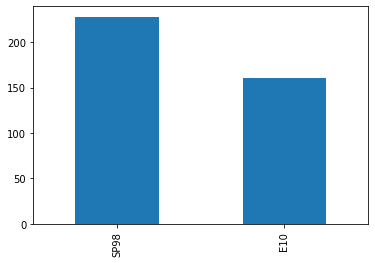

In [35]:
df.gas_type.value_counts().plot(kind='bar');

In [36]:
#We can see that the consume in E10 is bigger with the data we have.
df.groupby(['gas_type']).mean()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun
gas_type,,,,,,,,
E10,21.096250,4.931250,43.506250,21.917197,10.11875,0.043750,0.100000,0.075000
SP98,18.639912,4.899123,40.820175,21.938356,12.22807,0.100877,0.140351,0.087719


## Correlation matrix per fuel tipe

Lets go deeper with this analysis, we will plot the correlation matrix again and see if there are notorious differences

In [37]:
df_E10=df[df.gas_type == 'E10']
df_SP98=df[df.gas_type == 'SP98']

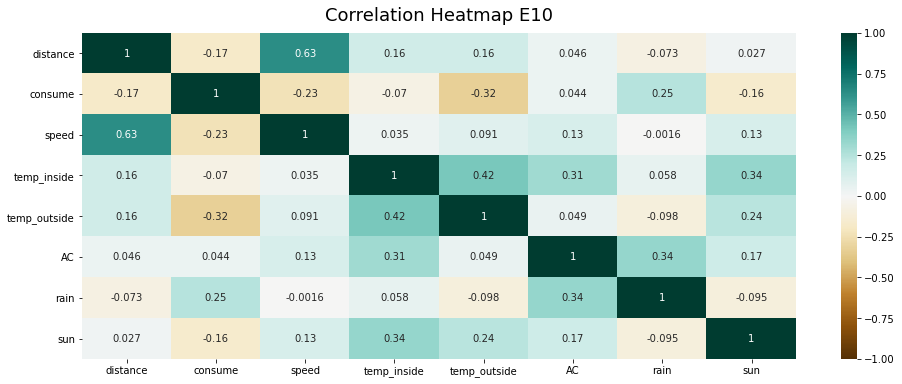

In [38]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_E10.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap E10', fontdict={'fontsize':18}, pad=12);

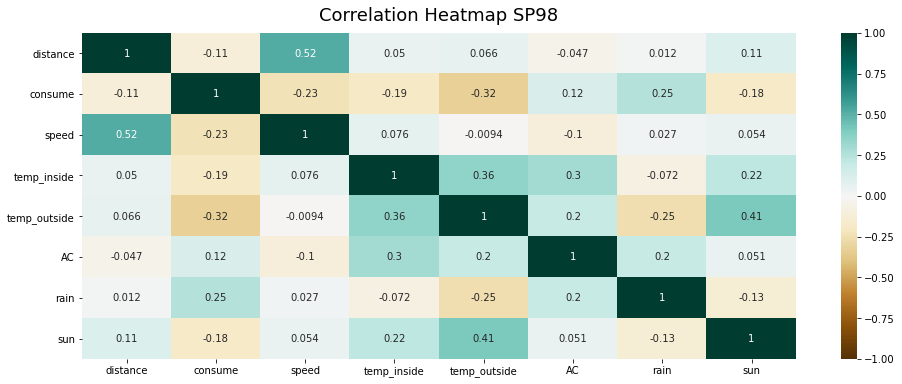

In [39]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_SP98.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap SP98', fontdict={'fontsize':18}, pad=12);

Insights:
1. Fuel SP98 is more correlated to the temp_inside thant E10
2. AC is higher correlated to consume in SP98 than in E10

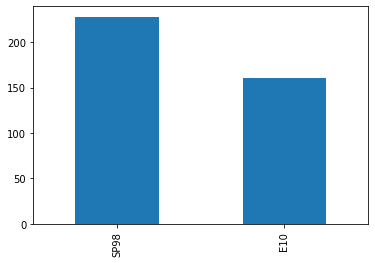

In [41]:
df.gas_type.value_counts().plot(kind='bar');

# Predict fuel consumption

I read the file again so I don't miss any column because I am biased about their impact.

In [42]:
df2=pd.read_excel('/Users/mikel/Documents/Projects/reto_data/measurements2.xlsx')

In [43]:
#Column 2 (consumption) will be the dependent variable
x = df2.iloc[:,[0,2,3,4,5,6,7,8,9]]
y = df2.iloc[:,1]

In [44]:
#Check null columns
nan_cols=x.isna().sum()

nan_cols[nan_cols>0]


temp_inside     12
specials       295
dtype: int64

In [45]:
#Fill null values with ' ' in this case
x.loc[:,['specials']] = x.loc[:,['specials']].fillna(' ')

In [46]:
# fill null values with mean
x['temp_inside']=x['temp_inside'].fillna(x['temp_inside'].mean())

In [47]:
# Now we do not have nulls
nan_cols=x.isna().sum()

nan_cols[nan_cols>0]


Series([], dtype: int64)

# Sklearn

In [48]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [49]:
# First of all, do get_dummies to encode specials and gas_type columns
encoder = LabelEncoder()
x = pd.get_dummies(x, prefix=['specials', 'gas_type'], drop_first=True)

In [50]:
#Train test split
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state=9, train_size = 0.8)

In [51]:
#Noramlize values
scale_x = StandardScaler()
x_train.iloc[:,0:4] = scale_x.fit_transform(x_train.iloc[:,0:4])
x_test.iloc[:,0:4] = scale_x.fit_transform(x_test.iloc[:,0:4])

In [52]:
#Linear regression & predict
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
y_pred = lin_reg.predict(x_test)

In [53]:
#set mean squared error 
rmse = mean_squared_error(y_test, y_pred)
rmse

0.9720417139513281

In [54]:
#predict by fuel type
sp98_y = lin_reg.predict(x_test[x_test['gas_type_SP98']==1])
E10_y = lin_reg.predict(x_test[x_test['gas_type_SP98']==0])


In [55]:
sp98_y.mean()

4.809541721770504

In [56]:
E10_y.mean()

5.139547010896096

In [57]:
Change=(E10_y.mean()-sp98_y.mean())
print(Change)
#E10 consumptions are higher than sp98 by 0.33 per 100km

0.3300052891255918


# Feature importance

We will make an overview of the weight every variable has in the fuel consumption

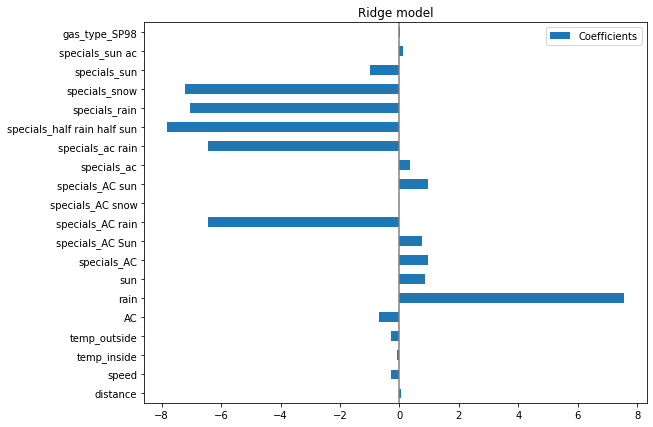

In [58]:
coefs = pd.DataFrame(
   lin_reg.coef_,
   columns=['Coefficients'], index=x_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5');

# Final thoughts

Without taking fuel's price into account, E10 consumptions are higher than using sp98. So fuel tipe is a relevant variable to consider.

